In [206]:
! pip install numpy pandas scikit-learn catboost matplotlib seaborn phik nltk wordcloud imblearn tensorflow

## Поменять

✅Ты делаешь токенизацию текстов, во первых хочется видеть более детальный анализ токенов (помимо облака слов еще диаграммы), проверка пунктуации. Во вторых токенизация для EDA и для модели должна быть одинаковая, иначе анализируешь ты одно, а на вход модели передается другое совсем, в чем нет смысла

✅Также токенизатор должен корректно работать с oov_token

✅Проверь что везде SEED фиксированный используется, чтобы нейронки обучались всегда одинаково для одних и тех же данных

✅Длина последовательностей = максимуму. Максимум часто определяется редкими хвостами → перерасход вычислений и регуляризации. Возьми, например, 95-й перцентиль длины

❓Нет стратификации при сплите train_test_split без stratify=y. Даже при балансе классов это повышает дисперсию метрик.

✅В первой LSTM у тебя Embedding(..., trainable=False) без загруженной матрицы — фактически «замороженная случайная» эмбеддинг-матрица. В этом нет смысла. Либо ты обучаешь эмбеддинги, либо используешь предобученные

✅Круто что ты нашел такую зависимость между 'subject' и 'target', для этого как раз графики и строятся, чтобы такое вот находить. В этом случае нам мл модель вообще не нужна, мы можем таргет предсказывать просто по subject и все, правильно что выкинул

✅Кажется, у тебя утечка данных при использовании 
X_train_text = vectorizer.fit_transform(X_train['text'].fillna(''))
X_test_text = vectorizer.fit_transform(X_test['text'].fillna(''))
CountVectorizer должен быть частью пайплайна

✅В реальных задачах ты никогда не будешь выкидывать текст статьи и оставлять только заголовок, поэтому используй сразу оба столбца

✅У каждой модели хотелось бы посмотреть важности признаков, а именно токенов, ведь это самое главное в текстовой классификации: увидеть какие слова влияют в какую сторону.

✅Добавь еще f1 метрику

✅Тюнинг гиперпараметров советую потренировать на нейронках, там их как раз много. Будет долго обучаться, но для тренировки стоит сделать

❓Еще общее замечание: код очень хаотичный и трудно разобрать, что зачем происходит. Старайся делить его на блоки и описывать что за чем происходит и логику своих действий, почему ты делаешь то или иное действие

✅Еще тебе нужно разбить данные по времени, то есть в test самые свежие новости, в train более ранние

✅Еще вспомнил, попробуй CNN использовать. Эта штука очень быстро обучается и точность высокая

____________________________________________________________________________________________________________________________________________________________________________________________________

✅Почему-то эта разбивка есть в improvements, но не в бейслайне. Сравнивать модели нужно на одной и той же выборке

❓TextPreprocessor - тебе не нужен в пайплайне, можешь просто метод создать и применить ко всему датасету
KerasTokenizerTransformer тоже не особо понял зачем, почему нельзя обычный Tokenizer добавить в пайплайн?

✅Не вижу смысла в двух слоях LSTM и доп Dense слое. Попробуй минимальный сетап, посмотри на метрики, пробуй улучшать, оставляй только нужное. Должен быть компромисс между качеством и скоростью обучения. То же самое с RNN. C CNN тоже слишком громоздкая архитектура получилась

## Начало

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from plots import *
import re

In [208]:
SEED = 42

In [209]:
stop_words = set(stopwords.words('english'))

In [210]:

def split_dataset(path, target_value, date_col='date', target_col='target', ratio=0.8): # т.к. датасет лежит в 2 файлах и надо в тест взять самые новые новости приходится выкручиваться
    df = pd.read_csv(path)
    df[target_col] = target_value  # ставим таргет
    df = df.sort_values(date_col).reset_index(drop=True)
    split_idx = int(len(df) * ratio)

    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    return X_train, X_test, y_train, y_test

# true = класс 1, false = класс 0
X_train_true, X_test_true, y_train_true, y_test_true = split_dataset('old/True.csv', target_value=1) # отдельно сплитим каждый датасет таким образом, что в тест попали самые свежие
X_train_false, X_test_false, y_train_false, y_test_false = split_dataset('old/Fake.csv', target_value=0)

# объединяем
X_train = pd.concat([X_train_true, X_train_false], ignore_index=True)
y_train = pd.concat([y_train_true, y_train_false], ignore_index=True)
X_test = pd.concat([X_test_true, X_test_false], ignore_index=True)
y_test = pd.concat([y_test_true, y_test_false], ignore_index=True)

# X_train['combo'] = X_train['title'] + X_train['text']
# X_test['combo'] = X_test['title'] + X_test['text']

# финальное распределение
print('Train distribution:\n', y_train.value_counts(normalize=True))
print('Test distribution:\n', y_test.value_counts(normalize=True))

Train distribution:
 target
0    0.522984
1    0.477016
Name: proportion, dtype: float64
Test distribution:
 target
0    0.522993
1    0.477007
Name: proportion, dtype: float64


In [211]:
X_train.head(10)

,title,text,subject,date
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",politicsNews,"April 1, 2016"
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,politicsNews,"April 1, 2016"
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,politicsNews,"April 1, 2016"
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,"April 1, 2016"
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"April 1, 2016"
5,Obama says 'no doubt' civilians have been kill...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"April 1, 2016"
6,Former New York deputy secretary of state accu...,NEW YORK (Reuters) - A former New York deputy ...,politicsNews,"April 1, 2016"
7,Hillary Clinton to propose $10 billion manufac...,WASHINGTON (Reuters) - Democratic presidential...,politicsNews,"April 1, 2016"
8,Trump's probability of winning nomination drop...,NEW YORK (Reuters) - The probability that Repu...,politicsNews,"April 1, 2016"
9,Senator Warren seeks investigation of insurers...,WASHINGTON (Reuters) - Senator Elizabeth Warre...,politicsNews,"April 1, 2016"


In [212]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED, shuffle=True, stratify=None)

X_train.drop(columns=['subject', 'date'], inplace=True)
X_test.drop(columns=['subject', 'date'], inplace=True)
X_val.drop(columns=['subject', 'date'], inplace=True)

# X_train.drop(columns=['subject', 'date', 'text'], inplace=True) # удаляем неинформативные колонки
# X_test.drop(columns=['subject', 'date', 'text'], inplace=True)
# X_val.drop(columns=['subject', 'date', 'text'], inplace=True)

X_train.head(10)

,title,text
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c..."
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...
5,Obama says 'no doubt' civilians have been kill...,WASHINGTON (Reuters) - U.S. President Barack O...
6,Former New York deputy secretary of state accu...,NEW YORK (Reuters) - A former New York deputy ...
7,Hillary Clinton to propose $10 billion manufac...,WASHINGTON (Reuters) - Democratic presidential...
8,Trump's probability of winning nomination drop...,NEW YORK (Reuters) - The probability that Repu...
9,Senator Warren seeks investigation of insurers...,WASHINGTON (Reuters) - Senator Elizabeth Warre...


In [213]:
len(X_val), len(X_test)

(4490, 4491)

блок для тестов

In [214]:
# def preprocessing(text):
#      text = text.lower()
#      text = re.sub('[^a-zA-Z]', ' ', text)
#      text = re.sub('\s+', ' ', text)
#      text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
#      text = re.sub(r'<.*?>', '', text)
#      return text 

# vectorized = np.vectorize(preprocessing)
# x_train = vectorized(X_train)
# x_test = vectorized(X_test)
# x_val = vectorized(X_val)

# print('the first 20 words of first train text after preprocessing:')
# visualize = ''
# counter = 0 

# for i in x_train[0].split(' '):
#     visualize = visualize + i + " " 
#     if counter>20:
#         break
#     counter = counter + 1 

# print(visualize)

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(x_train)

# train_seq = tokenizer.texts_to_sequences(x_train)
# test_seq = tokenizer.texts_to_sequences(x_test)
# val_seq = tokenizer.texts_to_sequences(x_val)
# vocab_size = len(tokenizer.word_index) + 1 
# max_length = max(len(sequence) for sequence in train_seq)

# train_seq = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = 'post')
# test_seq = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = 'post')
# val_seq = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = 'post')

## Preprocessing

In [215]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nemow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Я посмотрел, обычный керас tokenizer нельзя использовать без кастомных классов, т.к. у него нет своих методов .fit(), .transform()

Я пытался сделать через FunctionTransformer, но:

- Ему все равно надо прописывать .fit(), .transform()

- Он в запоминает только OVV токен

Поэтому оставил как есть, очистка текста тоже осталась в пайплайне. т.к. при инференсе все равно пришлось бы текст точно так же чистить 

In [216]:
from pipeline import CustomPipeline
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords

pipeline = CustomPipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nemow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [217]:
train_seq = pipeline.fit_transform(X_train) # применяем пайплайн
val_seq = pipeline.transform(X_val)
test_seq = pipeline.transform(X_test)

vocab_size = pipeline.named_steps['tokenizer'].vocab_size
max_length = pipeline.named_steps['tokenizer'].max_length

vocab_size, max_length

(98497, 35)

In [218]:
train_seq

array([[    2,  2711,  2765, ..., 45288, 25405,  5668],
       [  732,    21,    61, ...,     4,   318,    42],
       [   10,    46,  3451, ...,    16,   484,  1596],
       ...,
       [ 1093,   781,  7952, ...,  3434,   781,  7952],
       [  125,    41,   791, ...,  1669,   198,  5380],
       [ 2540,  1093,    28, ...,    85,   172,    11]],
      shape=(35917, 35), dtype=int32)

## LSTM

сделаем простую lstm модель

In [219]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings


warnings.filterwarnings('ignore')

In [220]:
epochs = 10
lr = 1e-3
embedding_dim = 10

model = Sequential([
    Input(shape = (max_length,)),
    Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = True), # установка trainable = True дала 2% 
    
    Bidirectional(LSTM(128)),

    Dropout(0.2),
    
    Dense(1, activation = 'sigmoid')
])
 
model.compile(optimizer = Adam(learning_rate = lr), loss = BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 35, 10)         │       984,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       142,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,127,563 (4.30 MB)

 Trainable params: 1,127,563 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [221]:
tf.config.list_physical_devices('GPU')

[]

In [222]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs, 
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9854 - loss: 0.0327 - val_accuracy: 0.9993 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.9982 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9993 - val_loss: 0.0060 - learning_rate: 2.0000e-04
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9999 - loss: 6.5332e-04 - val_accuracy: 0.9993 - val_loss: 0.0059 - learning_rate: 4.0000e-05
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9999 - loss: 5.8939e-04 - val_accuracy: 0.9993 - val_loss: 0.0060 - learning_rate: 8.0000e-06
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9999 - loss: 5.3797e-04 - val_accuracy: 0.9993 - val_loss: 0.0060 - learning_rate: 1.6000e-06


In [223]:
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 99.91 %
Test Accuracy  : 99.98 %


In [224]:
print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



точность примерно такая же как у классической модели поверх TF-IDF 

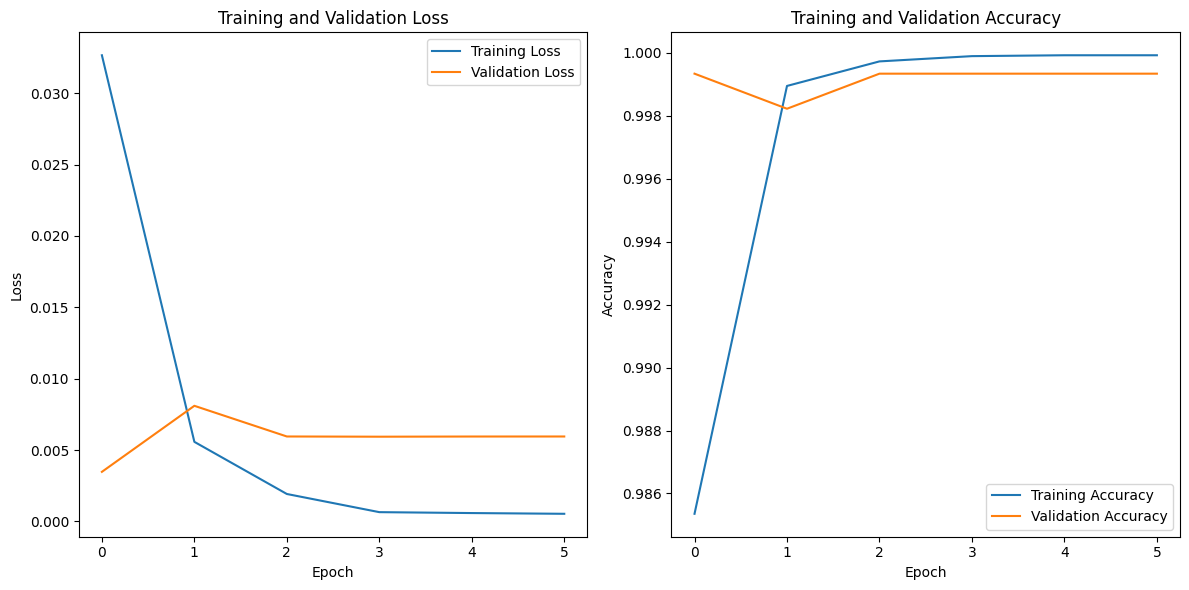

In [225]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## SimpleRNN

In [226]:
from tensorflow.keras.layers import SimpleRNN

epochs = 10
lr = 1e-3
embedding_dim = 10

model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),

    Bidirectional(SimpleRNN(128)),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])
 
model.compile(optimizer = Adam(learning_rate = lr), loss = BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 35, 10)         │       984,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │        35,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,811 (3.89 MB)

 Trainable params: 1,020,811 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [227]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs, 
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9846 - loss: 0.0477 - val_accuracy: 0.9971 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9970 - loss: 0.0115 - val_accuracy: 0.9996 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9979 - loss: 0.0079 - val_accuracy: 0.9913 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9991 - val_loss: 0.0055 - learning_rate: 2.0000e-04
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9993 - val_loss: 0.0042 - learning_rate: 4.0000e-05
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9999 - loss: 7.4133e-04 - val_accuracy: 0.9993 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - acc

In [228]:
y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Train Accuracy : 99.99 %
Test Accuracy  : 99.96 %
Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



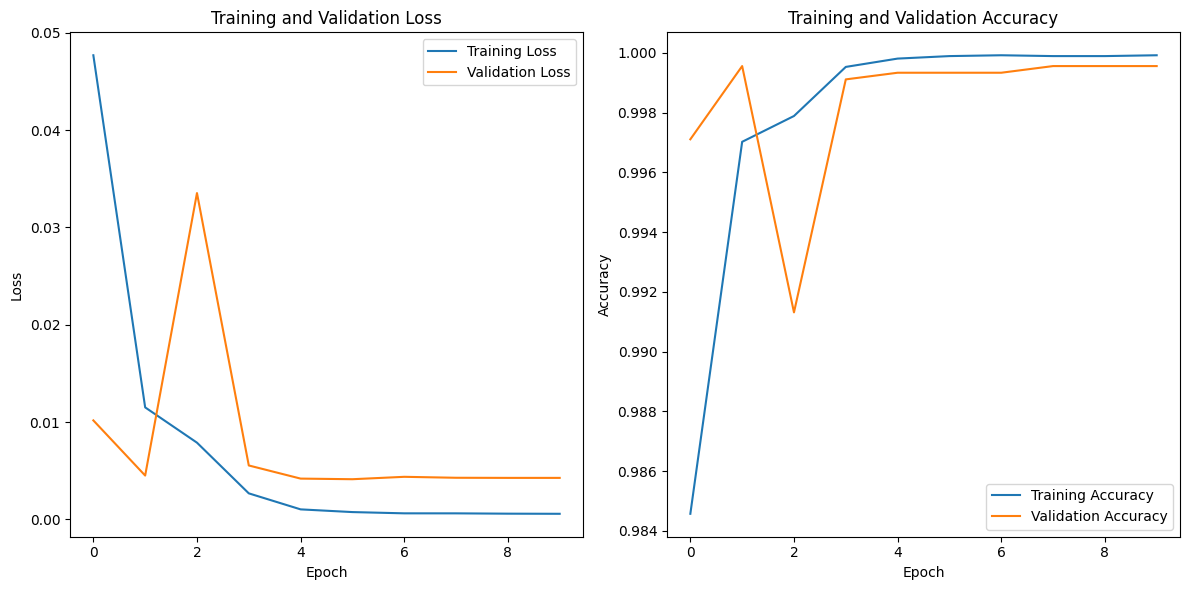

In [229]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

на 1-2% хуже LSTM, но обучаемых параметров в 5 раз меньше

## CNN

In [230]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense


epochs = 10
lr = 1e-3
embedding_dim = 10

inp = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True)(inp)

convs = [GlobalMaxPooling1D()(Conv1D(128, k, activation='relu')(x)) for k in [3, 4, 5]]

x = Concatenate()(convs)
x = Dense(256, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 35, 10)    │    984,970 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 33, 128)   │      3,968 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 32, 128)   │      5,248 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 31, 128)   │      6,528 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     98,560 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,099,531 (4.19 MB)

 Trainable params: 1,099,531 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

In [231]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs, 
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9898 - loss: 0.0303 - val_accuracy: 0.9993 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9987 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9999 - loss: 3.3514e-04 - val_accuracy: 0.9987 - val_loss: 0.0057 - learning_rate: 2.0000e-04
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9999 - loss: 1.2993e-04 - val_accuracy: 0.9987 - val_loss: 0.0049 - learning_rate: 4.0000e-05
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 7.4663e-05 - val_accuracy: 0.9987 - val_loss: 0.0048 - learning_rate: 8.0000e-06
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 6.9269e-05 - val_accuracy: 0.9987 - val_loss: 0.0048 - learning_rate: 1.6000e-06


In [232]:
y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Train Accuracy : 99.93 %
Test Accuracy  : 99.91 %
Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



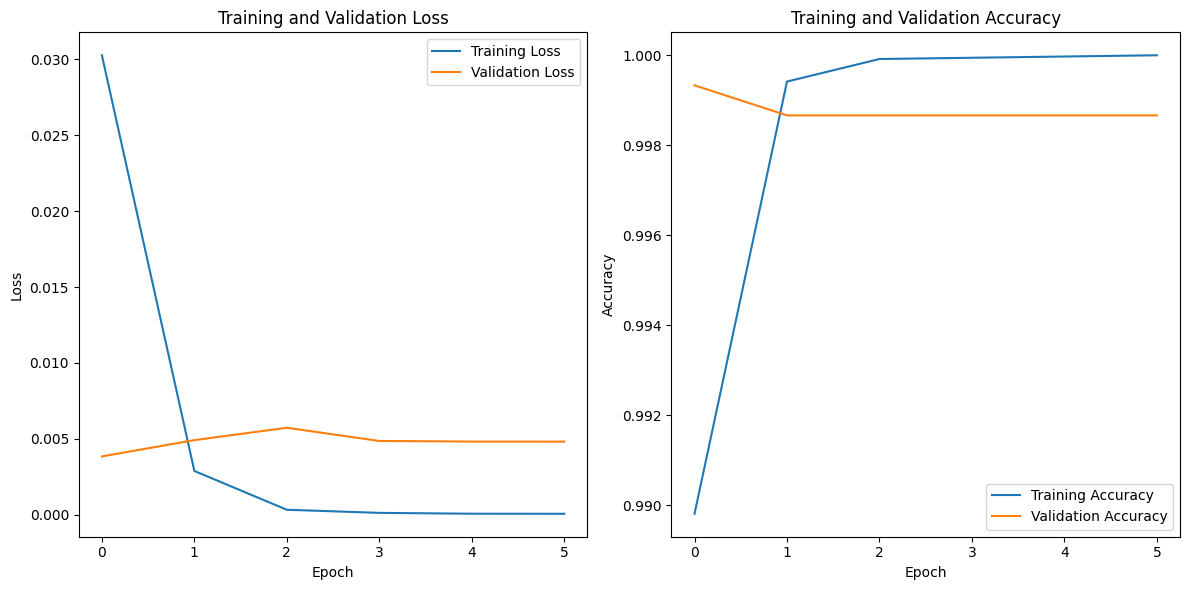

In [233]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Тюнинг гиперпараметров

In [234]:
! pip install keras-tuner

In [235]:
import keras_tuner as kt

использую автоподбор гиперпараметров на примере CNN выше

In [236]:
def build_model(hp):
    embedding_dim = hp.Int('embedding_dim', min_value=10, max_value=20, step=1)
    num_filters = hp.Int('num_filters', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    lr = hp.Choice('lr', [1e-4, 5e-4, 1e-3, 5e-3])

    inp = Input(shape=(max_length,))
    x = Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True)(inp)

    convs = [GlobalMaxPooling1D()(Conv1D(num_filters, k, activation='relu')(x)) for k in [3, 4, 5]]
    x = Concatenate()(convs)

    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='cnn_text'
)

tuner.search(train_seq, y_train, validation_data=(val_seq, y_val), epochs=10, batch_size=32)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 50 Complete [00h 02m 58s]
val_accuracy: 0.9993318319320679

Best val_accuracy So Far: 0.9997772574424744
Total elapsed time: 01h 33m 38s


In [256]:
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

embedding_dim: 14
num_filters: 64
dense_units: 256
dropout_rate: 0.0
lr: 0.0001


## Пробую TimeSeriesSplit

In [257]:
df = pd.read_csv('dataset.csv', index_col=0)

X = df.drop(columns=['target', 'subject', 'date'])
y = df['target']

In [258]:
X

,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l..."
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...


In [259]:
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostClassifier, Pool

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)

0:	test: 0.9022689	best: 0.9022689 (0)	total: 18.4ms	remaining: 18.3s
100:	test: 0.9950147	best: 0.9950509 (96)	total: 1.9s	remaining: 16.9s
200:	test: 0.9972455	best: 0.9972455 (200)	total: 3.68s	remaining: 14.6s
300:	test: 0.9980217	best: 0.9980217 (300)	total: 5.42s	remaining: 12.6s
400:	test: 0.9984390	best: 0.9984390 (400)	total: 7.13s	remaining: 10.7s
500:	test: 0.9986695	best: 0.9986806 (488)	total: 8.85s	remaining: 8.81s
600:	test: 0.9988259	best: 0.9988259 (600)	total: 10.5s	remaining: 6.99s
700:	test: 0.9988739	best: 0.9988759 (699)	total: 12.2s	remaining: 5.22s
800:	test: 0.9989092	best: 0.9989094 (797)	total: 13.9s	remaining: 3.46s
900:	test: 0.9990065	best: 0.9990076 (899)	total: 15.6s	remaining: 1.71s
999:	test: 0.9990015	best: 0.9990076 (899)	total: 17.3s	remaining: 0us

bestTest = 0.9990075886
bestIteration = 899

Shrink model to first 900 iterations.


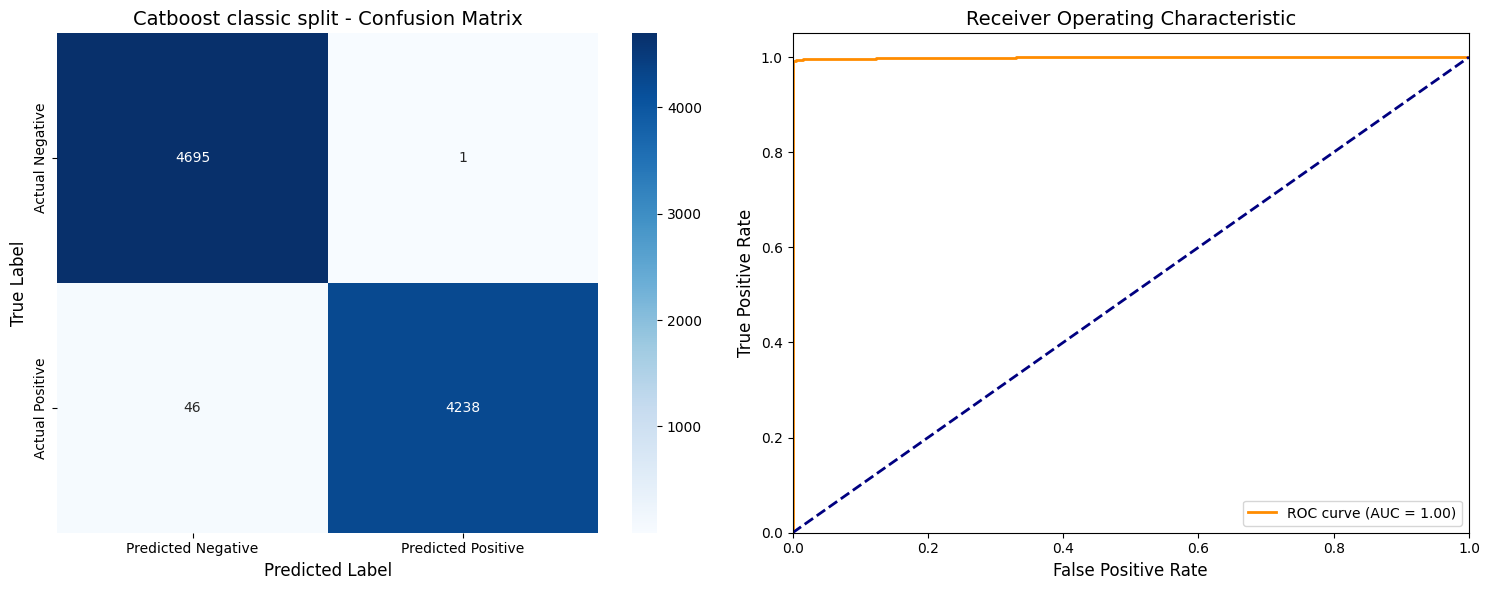


             CATBOOST CLASSIC SPLIT EVALUATION              

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9990
Average Precision 0.9992
         F1 Score 0.9948
        Precision 0.9950
           Recall 0.9945
         Accuracy 0.9948


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.999764 0.989262
Negative   0.990297 0.999787



In [261]:
model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        eval_metric='AUC',
        random_seed=42,
        verbose=100
    )

train_seq = pipeline.transform(X_train)
test_seq = pipeline.transform(X_test)

train_pool = Pool(train_seq, y_train)
val_pool = Pool(test_seq, y_test)

model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred = model.predict(test_seq)
y_proba = model.predict_proba(test_seq)[:, 1]

metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_proba,
    model_name='Catboost classic split',
    use_pr_curve=False
)

In [263]:
tscv = TimeSeriesSplit(n_splits=5)


for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    if y_train.nunique() < 2 or y_val.nunique() < 2:
        print(f"Skipping fold {fold}: not enough class variety")
        continue

    train_seq = pipeline.transform(X_train)
    test_seq = pipeline.transform(X_val)

    train_pool = Pool(train_seq, y_train)
    val_pool = Pool(test_seq, y_val)

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        eval_metric='AUC',
        random_seed=42,
        verbose=100
    )

    model.fit(train_pool, eval_set=val_pool, use_best_model=True)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    metrics = evaluate_classification(
        y_test=y_val,
        y_pred=y_pred,
        y_probs=y_proba,
        model_name='Catboost TimeSeries split',
        use_pr_curve=False
    )
    
    print(f'Fold {fold} done')

Skipping fold 0: not enough class variety
Skipping fold 1: not enough class variety
Skipping fold 2: not enough class variety
Skipping fold 3: not enough class variety
Skipping fold 4: not enough class variety


Кстати, опять же возникла проблема с разбиением. Из за того что df склеен из 2х датасетом, в начале у него только 0, а во второй половине 1 разбиение не работает. отсортировать его тоже не получится